In [99]:
import sys
from pathlib import Path

import pandas as pd
import geopandas as gpd
from shapely import wkt
import numpy as np
import matplotlib as mpl
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

mpl.rcParams["font.family"] = "Helvetica"  # will fall back silently if unavailable
mpl.rcParams["font.size"] = 9
mpl.rcParams["axes.titleweight"] = "heavy"

project_root = Path("/Users/dpro/projects/food_desert")

src_path = project_root / "src"
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

from food_desert import paths 

parcels_raw_path = project_root / "data" / "raw" / "Assessment_Parcels_20251112.csv"
parcel_mask_path = project_root / "data" / "interim" / "parcel_nearest_grocer_mask.csv"
neigh_path        = project_root / "data" / "reference" / "neighbourhoods.csv"

In [106]:
print(plt.rcParams["font.sans-serif"])
print(plt.rcParams["font.monospace"])

['DejaVu Sans', 'Bitstream Vera Sans', 'Computer Modern Sans Serif', 'Lucida Grande', 'Verdana', 'Geneva', 'Lucid', 'Arial', 'Helvetica', 'Avant Garde', 'sans-serif']
['DejaVu Sans Mono', 'Bitstream Vera Sans Mono', 'Computer Modern Typewriter', 'Andale Mono', 'Nimbus Mono L', 'Courier New', 'Courier', 'Fixed', 'Terminal', 'monospace']


1. Build parcel GeoDataFrame with distance + centroids

In [100]:
# load parcel distance mask (has dist_to_grocer_m, residents, etc.)
mask = pd.read_csv(parcel_mask_path)

# load raw parcels to get centroids
raw = pd.read_csv(parcels_raw_path, low_memory=False)

geom_cols = ["Roll Number", "Centroid Lat", "Centroid Lon"]
geom_cols = [c for c in geom_cols if c in raw.columns]
raw_geom = raw[geom_cols].copy()

# join geometry with distance/residents info
parcels = raw_geom.merge(mask, on="Roll Number", how="inner")

# make points from centroids
parcels_gdf = gpd.GeoDataFrame(
    parcels,
    geometry=gpd.points_from_xy(parcels["Centroid Lon"], parcels["Centroid Lat"]),
    crs="EPSG:4326",
)

# flag parcels > 500 m
parcels_gdf["far_500"] = parcels_gdf["dist_to_grocer_m"] > 500

parcels_gdf.head()

,Roll Number,Centroid Lat,Centroid Lon,neighbourhood_id,name,population,residents,dist_to_grocer_m,grocer_chain,grocer_store,geometry,far_500
0,1000001000,49.830137,-97.234696,93,Wilkes South,815,2,1779.519861,Red-River Co-op,Seasons,POINT (-97.2347 49.83014),True
1,1000005500,49.831649,-97.234565,93,Wilkes South,815,6,1634.613819,Red-River Co-op,Seasons,POINT (-97.23456 49.83165),True
2,1000008000,49.832113,-97.234524,93,Wilkes South,815,1,1590.978720,Red-River Co-op,Seasons,POINT (-97.23452 49.83211),True
3,1000008200,49.832423,-97.234497,93,Wilkes South,815,4,1562.186218,Red-River Co-op,Seasons,POINT (-97.2345 49.83242),True
4,1000008400,49.832887,-97.234457,93,Wilkes South,815,2,1519.454985,Red-River Co-op,Seasons,POINT (-97.23446 49.83289),True


2. Load neighbourhood outlines

In [101]:
neigh_df = pd.read_csv(neigh_path)
neigh_df["geometry"] = neigh_df["geometry"].apply(wkt.loads)
neigh_gdf = gpd.GeoDataFrame(neigh_df, geometry="geometry", crs="EPSG:4326")

3. Plot: black neighbourhood outlines + red parcels >500 m

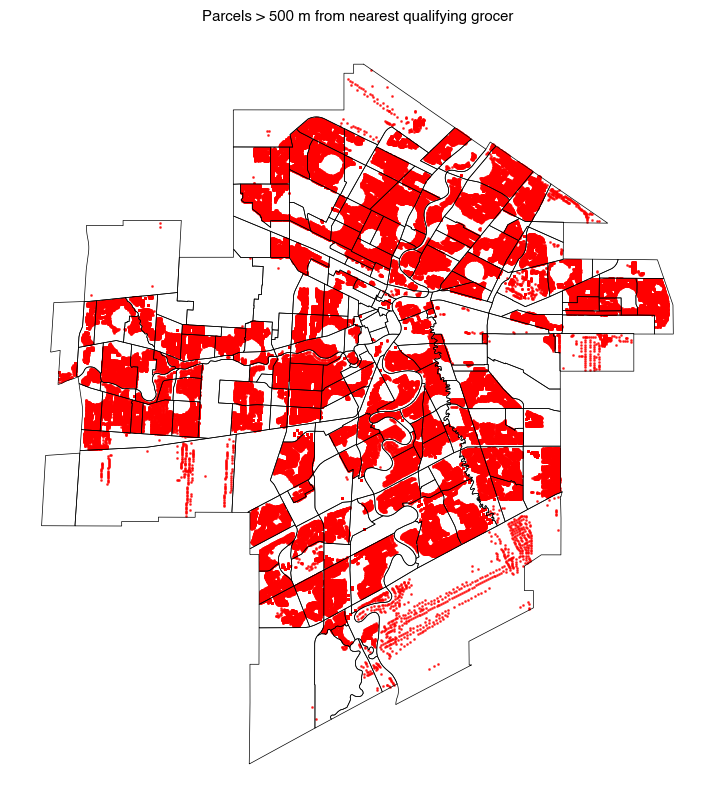

In [102]:
# base: neighbourhood outlines only
ax = neigh_gdf.boundary.plot(
    figsize=(10, 10),
    linewidth=0.5,
    color="black",
)

# overlay: parcels farther than 500 m, in red
far = parcels_gdf[parcels_gdf["far_500"]].copy()

far.plot(
    ax=ax,
    markersize=1,   # bump up/down if it looks too dense
    color="red",
    alpha=0.7,
)

ax.set_title("Parcels > 500 m from nearest qualifying grocer")
ax.set_axis_off()


# Heatmap

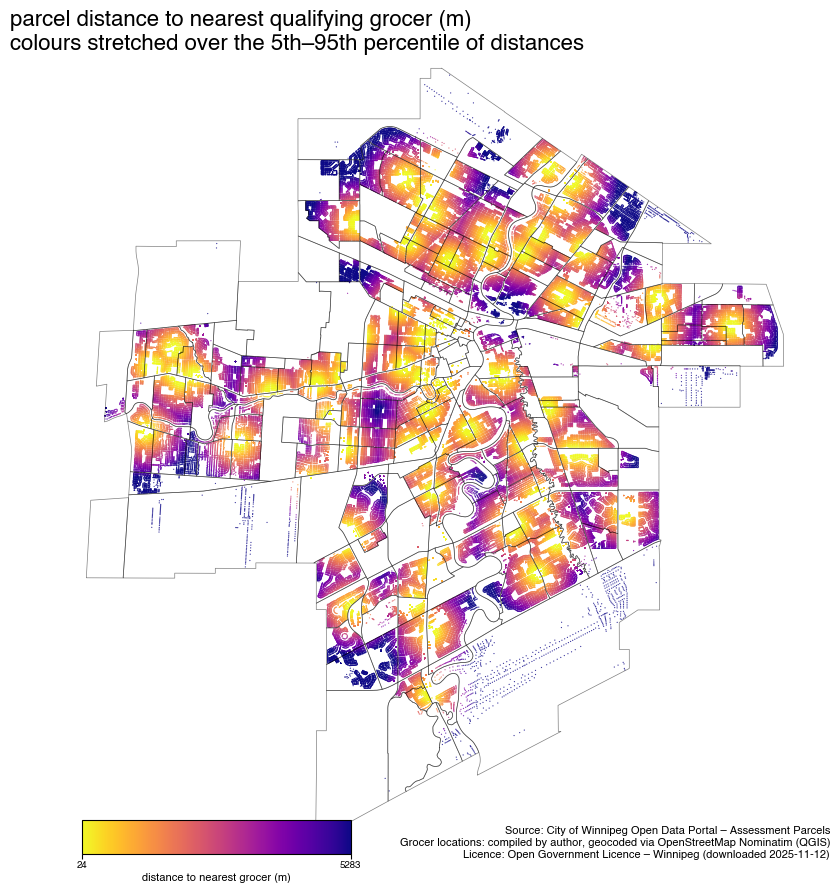

In [146]:
dist = parcels_gdf["dist_to_grocer_m"].dropna()
global_min = dist.min()
global_max = dist.max()
vmin_95, vmax_95 = np.percentile(dist, [5, 95])

parcels_gdf["dist_for_plot"] = parcels_gdf["dist_to_grocer_m"].clip(
    lower=vmin_95, upper=vmax_95
)

fig, ax = plt.subplots(figsize=(10, 10))

# base map
neigh_gdf.boundary.plot(
    ax=ax,
    linewidth=0.5,
    color="black",
    alpha=0.5,
)

# parcels
parcels_gdf.plot(
    ax=ax,
    column="dist_for_plot",
    cmap="plasma_r",
    markersize=0.8,
    alpha=0.8,
    linewidth=0,
    legend=False,
    vmin=vmin_95,
    vmax=vmax_95,
)

# colorbar setup
norm = Normalize(vmin=vmin_95, vmax=vmax_95)
sm = plt.cm.ScalarMappable(cmap="plasma_r", norm=norm)
sm._A = []

# small horizontal colorbar
cax = inset_axes(
    ax,
    width="35%",
    height="4%",
    loc="lower left",
    bbox_to_anchor=(0.04, 0.03, 1, 1),
    bbox_transform=ax.transAxes,
    borderpad=0,
)

cbar = fig.colorbar(sm, cax=cax, orientation="horizontal")
cbar.set_label("distance to nearest grocer (m)", fontsize=8, labelpad=2)
cbar.set_ticks([vmin_95, vmax_95])
cbar.set_ticklabels([f"{global_min:.0f}", f"{global_max:.0f}"])
cbar.ax.tick_params(labelsize=7, pad=1)

# adjust axes rectangle once so the map does not hit the figure edge
# these numbers are figure coordinates: left, bottom, right, top
fig.subplots_adjust(left=0.03, right=0.98, bottom=0.03, top=0.88)

ax.set_axis_off()

# figure level title, with padding from the top and left
fig.text(
    0.08, 0.90,
    "parcel distance to nearest qualifying grocer (m)\n"
    "colours stretched over the 5th–95th percentile of distances",
    ha="left",
    va="top",
    fontweight="bold",
    fontsize=16,
)

source_text = (
    "Source: City of Winnipeg Open Data Portal – Assessment Parcels\n"
    "Grocer locations: compiled by author, geocoded via OpenStreetMap Nominatim (QGIS)\n"
    "Licence: Open Government Licence – Winnipeg (downloaded 2025-11-12)"
)

fig.text(
    0.9, 0.05,           # x, y in figure coords (0–1); near bottom-right
    source_text,
    ha="right",
    va="bottom",
    fontsize=8,
)


plt.show()